In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import d2l.torch as d2l
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [248]:
from xgboost import XGBClassifier
# read data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.2)
# create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

## Model
let $g(p) = \ln\left( \frac{p}{1-p} \right)$ be the logit function, $X$ be the treatment, $Y$ be the binary outcome, $U$ be the confounder, and $Z$ be the instrumental variable. The generalized linear model can be defined as:
$$
g(\mathbb{E}[Y|X, U])= \beta^{T}X + \eta U
$$
where
$$
\mathbb{E}[X^{T}U]\neq 0, \quad \mathbb{E}[Z^{T}U]=0
$$


### Linear Case
Let the structrual equation be linear:
$$
X = \alpha Z + \gamma U + \epsilon
$$

In [249]:
n = 10000
Z = np.random.uniform(-3, 3, n)
alpha = 0.5
U = np.random.randn(n)
epsilon = np.random.randn(n) * 0.01
X = alpha * Z + U + epsilon
Z.size, X.size, U.size, epsilon.size

(10000, 10000, 10000, 10000)

<Axes: >

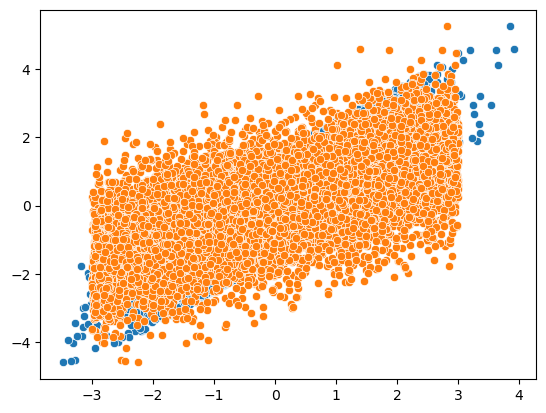

In [250]:
sns.scatterplot(x=U, y=X)
sns.scatterplot(x=Z, y=X)

/opt/miniconda3/envs/d2l/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

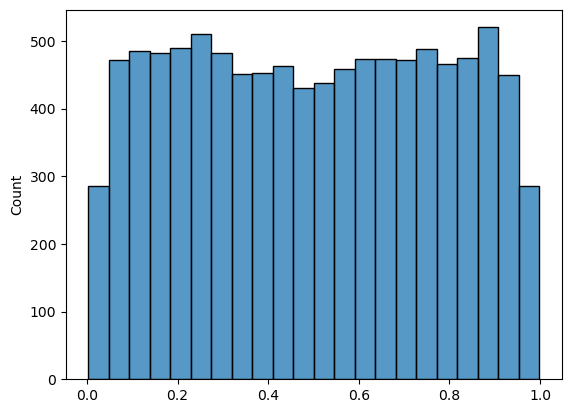

In [251]:
beta = 0.5
g_p = beta * X + U
p = 1 / (1 + np.exp(-g_p))
Y = np.random.binomial(1, p)
# plot the distribution of p
sns.histplot(p)

In [252]:
lr_gp = LinearRegression()
lr_gp.fit(X.reshape(-1, 1), g_p)
lr_gp.coef_, lr_gp.intercept_

(array([1.07606983]), 0.007026221932502465)

In [253]:
lr_iv = LinearRegression()
lr_iv.fit(Z.reshape(-1, 1), X)
X_hat = lr_iv.predict(Z.reshape(-1, 1))
lr_iv.coef_, lr_iv.intercept_

(array([0.50296691]), 0.004940422134507503)

In [254]:
lr_y_xhat = LinearRegression()
lr_y_xhat.fit(X_hat.reshape(-1, 1), g_p)
lr_y_xhat.coef_, lr_y_xhat.intercept_

(array([0.50586588]), 0.004870347611158468)

In [255]:
# Direct fitting
lg_direct = LogisticRegression()
lg_direct.fit(X.reshape(-1, 1), Y)
lg_direct.coef_, lg_direct.intercept_

(array([[0.98976756]]), array([-0.01686877]))

In [256]:
# measuring the accuracy
Y_pred = lg_direct.predict(X.reshape(-1, 1))
np.mean(Y_pred == Y)

0.7117

In [257]:
# Two stage fitting
lr_stage1 = LinearRegression()
lr_stage1.fit(Z.reshape(-1, 1), X)
X_hat = lr_stage1.predict(Z.reshape(-1, 1))
lg_stage2 = LogisticRegression()
lg_stage2.fit(X_hat.reshape(-1, 1), Y)
lg_stage2.coef_, lg_stage2.intercept_

(array([[0.35516379]]), array([-0.01703116]))

In [258]:
# Mofidied 3 stage fitting
def logit(p):
    return np.log(p / (1 - p))

# Calculate E[Y|X]
# Use logistic regressoin to estimate E[Y|X]
lg_stage1 = LogisticRegression()
lg_stage1.fit(X.reshape(-1, 1), Y)
E_Y_X = lg_stage1.predict_proba(X.reshape(-1, 1))[:, 1]
g_p_hat = logit(E_Y_X)
lr_stage2 = LinearRegression()
lr_stage2.fit(Z.reshape(-1, 1), g_p_hat)
g_Z_hat = lr_stage2.predict(Z.reshape(-1, 1))
lm_Z_X = LinearRegression()
lm_Z_X.fit(Z.reshape(-1, 1), X)
X_hat = lm_Z_X.predict(Z.reshape(-1, 1))
lm_X_hat = LinearRegression()
lm_X_hat.fit(X_hat.reshape(-1, 1), g_Z_hat)
lm_X_hat.coef_, lm_X_hat.intercept_


(array([0.98976756]), -0.016868772379280604)

#### Encapsulation

In [259]:
class sim_data(d2l.HyperParameters):
    def __init__(self, n, sigma_z=1, sigma_u=1, sigma_e=0.01, 
                 alpha=1, beta=1, gamma=1, eta = 1):
        super().__init__()
        self.save_hyperparameters()
        self.Z = np.random.normal(0, sigma_z, n)
        self.U = np.random.normal(0, sigma_u, n)
        epsilon = np.random.normal(0, sigma_e, n)
        self.X = alpha * self.Z + gamma * self.U + epsilon
        self.g_p = beta * self.X + eta * self.U
        self.p = 1 / (1 + np.exp(-self.g_p))
        self.Y = np.random.binomial(1, self.p)
        
    def plot_Z_X(self):
        sns.scatterplot(x=self.Z, y=self.X)
        
    def plot_U_X(self):
        sns.scatterplot(x=self.U, y=self.X)
        
    def plot_p(self):
        sns.histplot(self.p)


In [260]:
class two_stage_logit():
    def __init__(self, predictor=LinearRegression()):
        self.X_hat = None  
        self.predictor = predictor
    
    def fit(self, X, Y, Z):
        self.predictor.fit(Z.reshape(-1, 1), X)
        self.X_hat = self.predictor.predict(Z.reshape(-1, 1))
        lg = LogisticRegression()
        lg.fit(self.X_hat.reshape(-1, 1), Y)
        self.coef_ = lg.coef_
        self.intercept_ = lg.intercept_
    
    

In [261]:
class three_stage_logit():
    def __init__(self, classifier=XGBClassifier(), regressor = LinearRegression()):
        self.X_hat = None
        self.g_p_hat = None
        self.classifier = classifier
        self.regressor = regressor
    
    def logit(self, p):
        return np.log( p / (1 - p) )
    
    def fit(self, X, Y, Z):
        self.classifier.fit(X.reshape(-1, 1), Y)
        E_Y_X = self.classifier.predict_proba(X.reshape(-1, 1))[:, 1]
        
        # print(self.classifier.predict_proba(X.reshape(-1, 1)))
        # print(E_Y_X)
        
        self.g_p_hat = self.logit(E_Y_X)
        
        # self.regressor.fit(Z.reshape(-1, 1), self.g_p_hat)
        # self.g_Z_hat = self.regressor.predict(Z.reshape(-1, 1))
        
        lm_Z_X = LinearRegression()
        lm_Z_X.fit(Z.reshape(-1, 1), X)
        self.X_hat = lm_Z_X.predict(Z.reshape(-1, 1))
        lm_X_hat = LinearRegression()
        lm_X_hat.fit(self.X_hat.reshape(-1, 1), self.g_p_hat)
        self.coef_ = lm_X_hat.coef_
        self.intercept_ = lm_X_hat.intercept_
        


In [262]:
data = sim_data(n=10000, sigma_z=1, sigma_u=1, sigma_e=0.01, alpha=1, beta=4, gamma=3)

lg = LogisticRegression()
lg.fit(data.X.reshape(-1, 1), data.Y)
print(lg.coef_, lg.intercept_, '\n')

tsl = two_stage_logit()
tsl.fit(data.X, data.Y, data.Z)
print(tsl.coef_, tsl.intercept_, '\n')

s3l = three_stage_logit()
s3l.fit(data.X, data.Y, data.Z)
print(s3l.coef_, s3l.intercept_)

[[4.19872211]] [0.0022229] 

[[0.50591538]] [0.01190634] 



[2.11277838] 0.1887342768497579


### The effect of $\gamma$

In [263]:
k = np.linspace(-2, 2, 100)
lg_coef = np.array([])
tslg_coef = np.array([])
s3lg_coef = np.array([])      
beta = 1

for gamma in np.power(10, k):
    data = sim_data(n=10000, gamma=gamma, beta=beta)
    
    lg = LogisticRegression()
    lg.fit(data.X.reshape(-1, 1), data.Y)
    lg_coef = np.append(lg_coef, lg.coef_)
    
    tslg = two_stage_logit()
    tslg.fit(data.X, data.Y, data.Z)
    tslg_coef = np.append(tslg_coef, tslg.coef_)
    
    s3lg = three_stage_logit()
    s3lg.fit(data.X, data.Y, data.Z)
    s3lg_coef = np.append(s3lg_coef, s3lg.coef_)


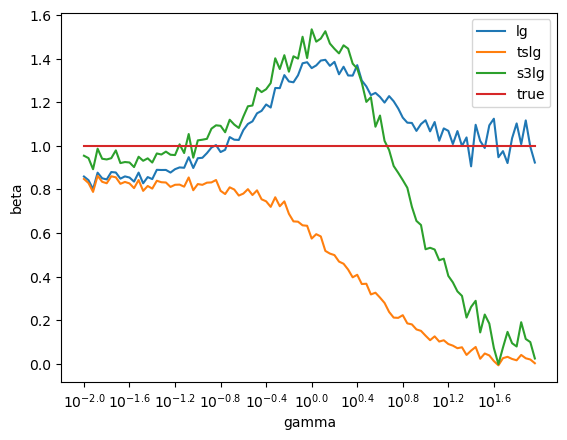

In [264]:
plt.plot(k, lg_coef, label='lg')
plt.plot(k, tslg_coef, label='tslg')
plt.plot(k, s3lg_coef, label='s3lg')
plt.plot(k, beta * np.ones(100), label='true')
plt.xticks(k[::10], [f'$10^{{{round(ki, 1)}}}$' for ki in k[::10]])
plt.xlabel('gamma')
plt.ylabel('beta')
plt.legend()

In [265]:
lg_coef = np.array([])
tslg_coef = np.array([])
s3lg_coef = np.array([])      
beta = 1

for gamma in np.linspace(-5, 5, 100):
    data = sim_data(n=10000, gamma=gamma, beta=beta)
    
    lg = LogisticRegression()
    lg.fit(data.X.reshape(-1, 1), data.Y)
    lg_coef = np.append(lg_coef, lg.coef_)
    
    tslg = two_stage_logit()
    tslg.fit(data.X, data.Y, data.Z)
    tslg_coef = np.append(tslg_coef, tslg.coef_)
    
    s3lg = three_stage_logit()
    s3lg.fit(data.X, data.Y, data.Z)
    s3lg_coef = np.append(s3lg_coef, s3lg.coef_)

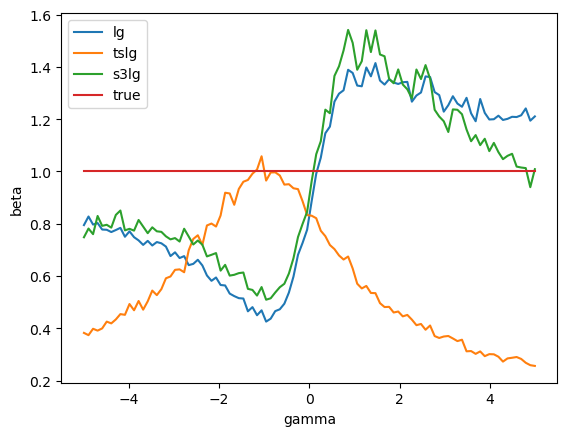

In [266]:
plt.plot(np.linspace(-5, 5, 100), lg_coef, label='lg')
plt.plot(np.linspace(-5, 5, 100), tslg_coef, label='tslg')
plt.plot(np.linspace(-5, 5, 100), s3lg_coef, label='s3lg')
plt.plot(np.linspace(-5, 5, 100), beta * np.ones(100), label='true')
plt.xlabel('gamma')
plt.ylabel('beta')
plt.legend()

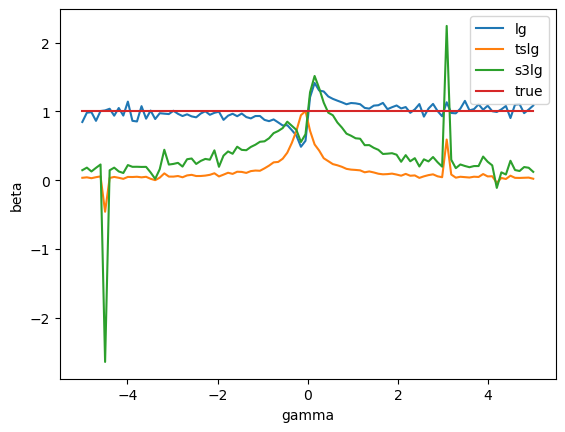

In [267]:
lg_coef = np.array([])
tslg_coef = np.array([])
s3lg_coef = np.array([])      
beta = 1

for gamma in np.linspace(-50, 50, 100):
    data = sim_data(n=10000, gamma=gamma, beta=beta)
    
    lg = LogisticRegression()
    lg.fit(data.X.reshape(-1, 1), data.Y)
    lg_coef = np.append(lg_coef, lg.coef_)
    
    tslg = two_stage_logit()
    tslg.fit(data.X, data.Y, data.Z)
    tslg_coef = np.append(tslg_coef, tslg.coef_)
    
    s3lg = three_stage_logit()
    s3lg.fit(data.X, data.Y, data.Z)
    s3lg_coef = np.append(s3lg_coef, s3lg.coef_)

plt.plot(np.linspace(-5, 5, 100), lg_coef, label='lg')
plt.plot(np.linspace(-5, 5, 100), tslg_coef, label='tslg')
plt.plot(np.linspace(-5, 5, 100), s3lg_coef, label='s3lg')
plt.plot(np.linspace(-5, 5, 100), beta * np.ones(100), label='true')
plt.xlabel('gamma')
plt.ylabel('beta')
plt.legend()

### The effect of $\beta$

In [268]:
k = np.linspace(-2, 2, 100)
lg_dif = np.array([])
tslg_dif = np.array([])
s3lg_dif = np.array([])      

for beta in np.power(10, k):
    data = sim_data(n=10000, beta=beta)
    
    lg = LogisticRegression()
    lg.fit(data.X.reshape(-1, 1), data.Y)
    lg_dif = np.append(lg_dif, np.abs(lg.coef_ - beta)/beta)
    
    tslg = two_stage_logit()
    tslg.fit(data.X, data.Y, data.Z)
    tslg_dif = np.append(tslg_dif, np.abs(tslg.coef_ - beta)/beta)
    
    s3lg = three_stage_logit()
    s3lg.fit(data.X, data.Y, data.Z)
    s3lg_dif = np.append(s3lg_dif, np.abs(s3lg.coef_ - beta)/beta)

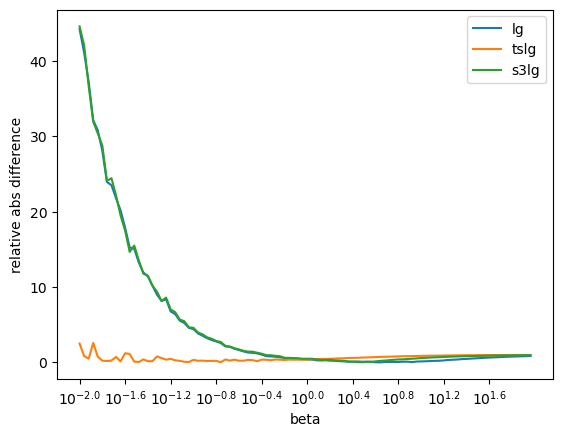

In [269]:
plt.plot(k, lg_dif, label='lg')
plt.plot(k, tslg_dif, label='tslg')
plt.plot(k, s3lg_dif, label='s3lg')
plt.xticks(k[::10], [f'$10^{{{round(ki, 1)}}}$' for ki in k[::10]])
plt.xlabel('beta')
plt.ylabel('relative abs difference')
plt.legend()

In [270]:
lg_dif = np.array([])
tslg_dif = np.array([])
s3lg_dif = np.array([])

for beta in np.linspace(-10, 10, 100):
    
    data = sim_data(n=10000, beta=beta)
    
    lg = LogisticRegression()
    lg.fit(data.X.reshape(-1, 1), data.Y)
    
    lg_dif = np.append(lg_dif, np.abs(lg.coef_ - beta))
    
    tslg = two_stage_logit()
    tslg.fit(data.X, data.Y, data.Z)
    tslg_dif = np.append(tslg_dif, np.abs(tslg.coef_ - beta))
    
    s3lg = three_stage_logit()
    s3lg.fit(data.X, data.Y, data.Z)
    s3lg_dif = np.append(s3lg_dif, np.abs(s3lg.coef_ - beta))

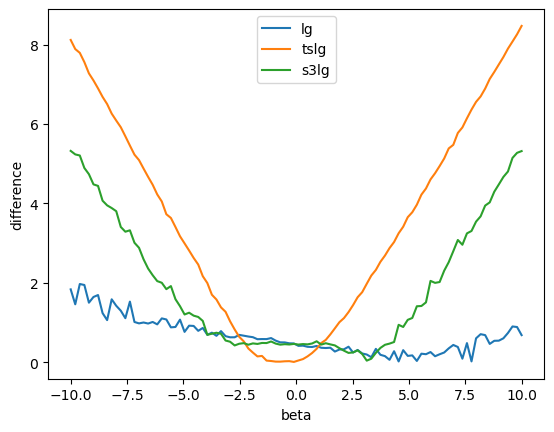

In [271]:
plt.plot(np.linspace(-10, 10, 100), lg_dif, label='lg')
plt.plot(np.linspace(-10, 10, 100), tslg_dif, label='tslg')
plt.plot(np.linspace(-10, 10, 100), s3lg_dif, label='s3lg')
plt.xlabel('beta')
plt.ylabel('difference')
plt.legend()

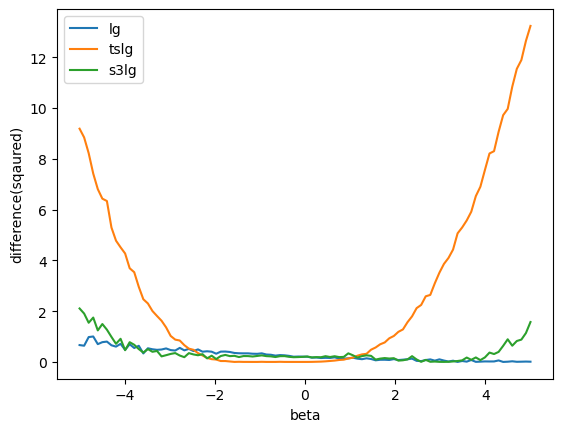

In [272]:
lg_dif = np.array([])
tslg_dif = np.array([])
s3lg_dif = np.array([])      

for beta in np.linspace(-5, 5, 100):
    data = sim_data(n=10000, beta=beta)
    
    lg = LogisticRegression()
    lg.fit(data.X.reshape(-1, 1), data.Y)
    
    lg_dif = np.append(lg_dif, np.square(lg.coef_ - beta))
    
    tslg = two_stage_logit()
    tslg.fit(data.X, data.Y, data.Z)
    tslg_dif = np.append(tslg_dif, np.square(tslg.coef_ - beta))
    
    s3lg = three_stage_logit()
    s3lg.fit(data.X, data.Y, data.Z)
    s3lg_dif = np.append(s3lg_dif, np.square(s3lg.coef_ - beta))
    
plt.plot(np.linspace(-5, 5, 100), lg_dif, label='lg')
plt.plot(np.linspace(-5, 5, 100), tslg_dif, label='tslg')
plt.plot(np.linspace(-5, 5, 100), s3lg_dif, label='s3lg')
plt.xlabel('beta')
plt.ylabel('difference(sqaured)')
plt.legend()

### Effect of Sigma_u

/var/folders/5z/8hzvmhln5p36t4tdqc9c52z40000gn/T/ipykernel_22337/136573033.py:11: RuntimeWarning: overflow encountered in exp
  self.p = 1 / (1 + np.exp(-self.g_p))


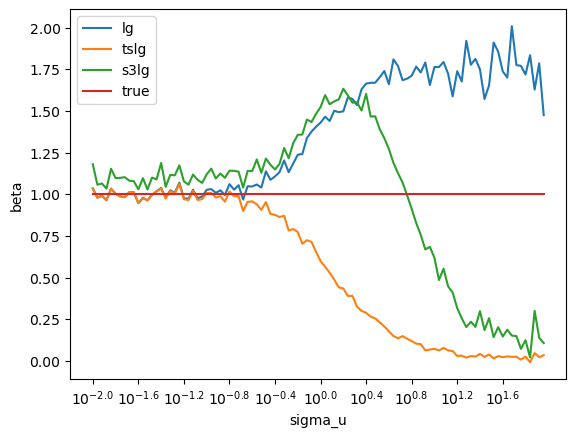

In [273]:
k = np.linspace(-2, 2, 100)
lg_coef = np.array([])
tslg_coef = np.array([])
s3lg_coef = np.array([])
beta = 1

for sigama in np.power(10, k):
    data = sim_data(n=10000, sigma_u=sigama, beta=beta)
    
    lg = LogisticRegression()
    lg.fit(data.X.reshape(-1, 1), data.Y)
    lg_coef = np.append(lg_coef, lg.coef_)
    
    tslg = two_stage_logit()
    tslg.fit(data.X, data.Y, data.Z)
    tslg_coef = np.append(tslg_coef, tslg.coef_)
    
    s3lg = three_stage_logit()
    s3lg.fit(data.X, data.Y, data.Z)
    s3lg_coef = np.append(s3lg_coef, s3lg.coef_)
    
plt.plot(k, lg_coef, label='lg')
plt.plot(k, tslg_coef, label='tslg')
plt.plot(k, s3lg_coef, label='s3lg')
plt.plot(k, beta * np.ones(100), label='true')
plt.xticks(k[::10], [f'$10^{{{round(ki, 1)}}}$' for ki in k[::10]])
plt.xlabel('sigma_u')
plt.ylabel('beta')
plt.legend()

### Effect of eta

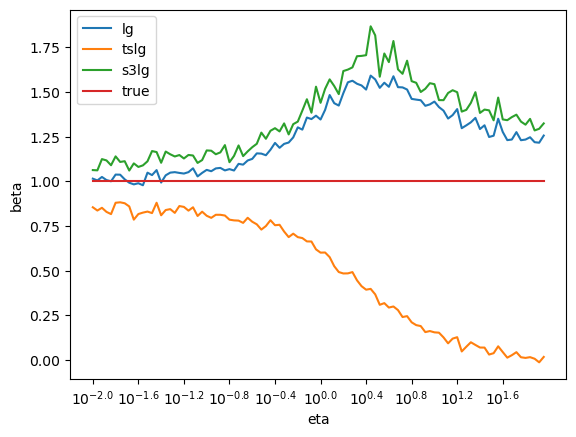

In [274]:
k = np.linspace(-2, 2, 100)
lg_coef = np.array([])
tslg_coef = np.array([])
s3lg_coef = np.array([])
beta = 1

for eta in np.power(10, k):
    data = sim_data(n=10000, eta=eta, beta=beta)
    
    lg = LogisticRegression()
    lg.fit(data.X.reshape(-1, 1), data.Y)
    lg_coef = np.append(lg_coef, lg.coef_)
    
    tslg = two_stage_logit()
    tslg.fit(data.X, data.Y, data.Z)
    tslg_coef = np.append(tslg_coef, tslg.coef_)
    
    s3lg = three_stage_logit()
    s3lg.fit(data.X, data.Y, data.Z)
    s3lg_coef = np.append(s3lg_coef, s3lg.coef_)
    
plt.plot(k, lg_coef, label='lg')
plt.plot(k, tslg_coef, label='tslg')
plt.plot(k, s3lg_coef, label='s3lg')
plt.plot(k, beta * np.ones(100), label='true')
plt.xticks(k[::10], [f'$10^{{{round(ki, 1)}}}$' for ki in k[::10]])
plt.xlabel('eta')
plt.ylabel('beta')
plt.legend()

### Effect of alpha

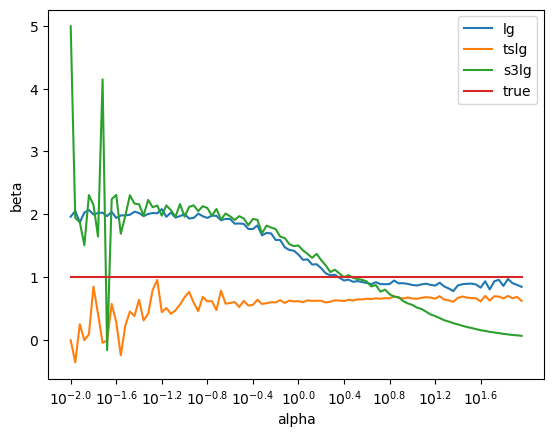

In [292]:
k = np.linspace(-2, 2, 100)
lg_coef = np.array([])
tslg_coef = np.array([])
s3lg_coef = np.array([])
beta = 1

for alpha in np.power(10, k):
    data = sim_data(n=10000, alpha=alpha, beta=beta)
    
    lg = LogisticRegression()
    lg.fit(data.X.reshape(-1, 1), data.Y)
    lg_coef = np.append(lg_coef, lg.coef_)
    
    tslg = two_stage_logit()
    tslg.fit(data.X, data.Y, data.Z)
    tslg_coef = np.append(tslg_coef, tslg.coef_)
    
    s3lg = three_stage_logit()
    s3lg.fit(data.X, data.Y, data.Z)
    s3lg_coef = np.append(s3lg_coef, s3lg.coef_)
    
plt.plot(k, lg_coef, label='lg')
plt.plot(k, tslg_coef, label='tslg')
plt.plot(k, s3lg_coef, label='s3lg')
plt.plot(k, beta * np.ones(100), label='true')
plt.xticks(k[::10], [f'$10^{{{round(ki, 1)}}}$' for ki in k[::10]])
plt.xlabel('alpha')
plt.ylabel('beta')
plt.legend()